In [1]:
import tensorflow as tf
import tensorflow_datasets as datasets
from tensorflow.keras import layers, models, losses as loss, optimizers as optimizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

This gan model will try to generate shapes on its own. It is trained on emnist model.

In [2]:
emnist = datasets.load('emnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/697932 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteJGBP2M/emnist-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/116323 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteJGBP2M/emnist-test.tfrecord*...:   0%|     …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.


**Steps to create a gan:**


---


1. preprocess the data fetched
2. visualize the images fetched and check if reshaping is required.
3. create the generator and discriminator model.
4. define optimizers (*with suitable learning rates*) and loss functions.
5. before training once test the models for any error.
6. create a custom training loop
7. create required callbacks (*optional*)
8. compile and fit the model and test out the trained model.


```
Preprocess the images fetched
```

In [3]:
def preprocess_dataset(dataset):
  ds = dataset.map(lambda image: image['image'] / 255)
  ds = ds.cache()
  ds = ds.shuffle(len(dataset))
  ds = ds.batch(128)
  ds = ds.prefetch(64)
  return ds

emnist = preprocess_dataset(emnist)

In [4]:
len(emnist.as_numpy_iterator().next())

128



```
Visualization of images
```



In [5]:
def visualize_n_images(n):
  fig, ax = plt.subplots(ncols=n, figsize=(7, 7))
  for index in range(n):
    image = emnist.as_numpy_iterator().next()[random.randint(0, 128)]
    ax[index].set_title(f"Shape:{image.shape}", size=8)
    ax[index].imshow(image)
    ax[index].axis("off")

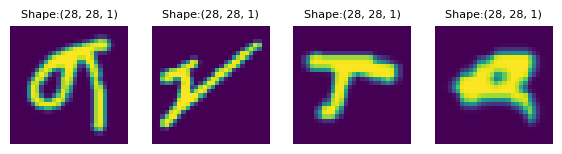

In [6]:
visualize_n_images(4)

All images are in shape of (28, 28, 1) so no reshaping is required.

```
Creating the generator model
```

In [7]:
def generator_model():
  model = models.Sequential([
      layers.Dense(7*7*128, input_dim=128),
      layers.LeakyReLU(0.2),
      layers.Reshape((7, 7, 128)),
      layers.UpSampling2D(),
      layers.Conv2D(128, 5, padding='same'),
      layers.LeakyReLU(0.2),
      layers.UpSampling2D(),
      layers.Conv2D(128, 5, padding='same'),
      layers.LeakyReLU(0.2),
      layers.Conv2D(128, 5, padding='same'),
      layers.LeakyReLU(0.2),
      layers.Conv2D(1, 5, padding='same', activation='sigmoid')
  ], name='generator_model')

  return model

In [8]:
generator = generator_model()
generator.summary()

Model: "generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                   

In [9]:
# test the generator model
image = generator.predict(np.random.randn(1, 128, 1))

1/1 [==============================] - 8s 8s/step


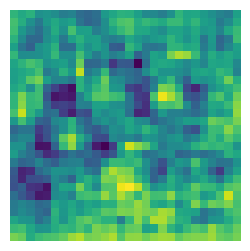

In [10]:
plt.figure(figsize=(3, 3))
plt.imshow(np.squeeze(image))
plt.axis("off")
plt.show()

This does not look like our dataset images but still we have something to start with

```
Creating a discriminator model
```

In [11]:
def discriminator_model():
  model = models.Sequential([
      layers.Conv2D(32, 5, input_shape=(28, 28, 1)),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4), # adding noise to discriminator
      layers.Conv2D(64, 5),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),
      layers.Conv2D(128, 5),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.4),
      layers.Flatten(),
      layers.Dense(1, 'sigmoid')
  ])
  return model

In [12]:
discriminator = discriminator_model()
discriminator.predict(image), discriminator.summary()

1/1 [==============================] - 0s 154ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 co

(array([[0.5007785]], dtype=float32), None)

Here the discriminator is 50.1 % sure that the generated image is real and not a fake but that percentage is no good as it is just guessing.




`
So we created our generator and discriminator model and tested them for any errors. So now we have to train the models so we can fit the GAN on our dataset. The training of a GAN is the tricky part as we need to traing generator with discriminator and training of discriminator should not be too fast.
`

```
Creating the custom training loop
```

In [13]:
# defining optimizers and loss functions
g_opt = optimizer.Adam(learning_rate = 1e-4)
d_opt = optimizer.Adam(learning_rate = 1e-5)
g_loss = loss.BinaryCrossentropy()
d_loss = loss.BinaryCrossentropy()

In [14]:
class Emnist(models.Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.d_opt = d_opt
    self.g_opt = g_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

    with tf.GradientTape() as dtape:
      real_images_labels = self.discriminator(real_images, training = True)
      fake_images_labels = self.discriminator(fake_images, training = True)
      labels = tf.concat([real_images_labels, fake_images_labels], axis = 0)
      true_labels = tf.concat([tf.zeros_like(real_images_labels),
                               tf.ones_like(fake_images_labels)], axis = 0)

      real_noise = 0.15 * tf.random.uniform(shape=tf.shape(real_images_labels))
      fake_noise = -0.15 * tf.random.uniform(shape=tf.shape(fake_images_labels))
      true_labels += tf.concat([real_noise, fake_noise], axis = 0)

      total_d_loss = self.d_loss(true_labels, labels)
    dgrad = dtape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as gtape:
      generated_images = self.generator(tf.random.uniform((128, 128, 1)), training = True)
      generated_labels = self.discriminator(generated_images, training = False)
      true_labels = tf.zeros_like(generated_labels)
      total_g_loss = self.g_loss(true_labels, generated_labels)
    ggrad = gtape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
    return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [15]:
emnist_model = Emnist(generator, discriminator)

In [16]:
emnist_model.compile(g_opt, d_opt, g_loss, d_loss)

In [17]:
hist = emnist_model.fit(emnist, epochs=10, steps_per_epoch=len(emnist))

Epoch 1/10
5453/5453 [==============================] - 561s 101ms/step - d_loss: 0.4632 - g_loss: 1.0686
Epoch 2/10
5453/5453 [==============================] - 547s 100ms/step - d_loss: 0.2763 - g_loss: 2.0951
Epoch 3/10
5453/5453 [==============================] - 547s 100ms/step - d_loss: 0.2793 - g_loss: 2.0681
Epoch 4/10
5453/5453 [==============================] - 545s 100ms/step - d_loss: 0.2702 - g_loss: 2.5168
Epoch 5/10
5453/5453 [==============================] - 544s 100ms/step - d_loss: 0.2685 - g_loss: 2.7434
Epoch 6/10
5453/5453 [==============================] - 545s 100ms/step - d_loss: 0.2679 - g_loss: 2.7722
Epoch 7/10
5453/5453 [==============================] - 544s 100ms/step - d_loss: 0.2677 - g_loss: 2.7605
Epoch 8/10
5453/5453 [==============================] - 544s 100ms/step - d_loss: 0.2676 - g_loss: 2.7558
Epoch 9/10
5453/5453 [==============================] - 550s 101ms/step - d_loss: 0.2674 - g_loss: 2.7596
Epoch 10/10
5453/5453 [=======================

In [18]:
epochs = range(len(hist.history['d_loss']))

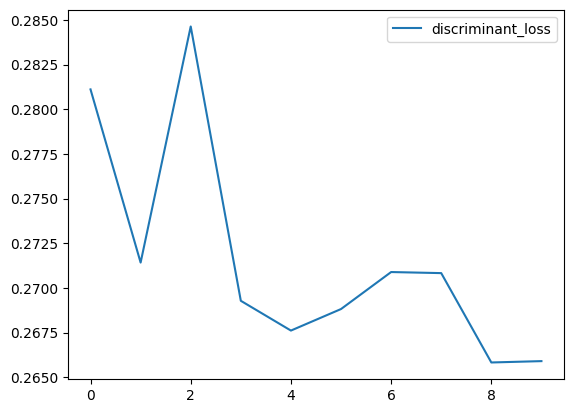

In [19]:
plt.plot(hist.history['d_loss'], label = 'discriminant_loss')
plt.legend()
plt.show()

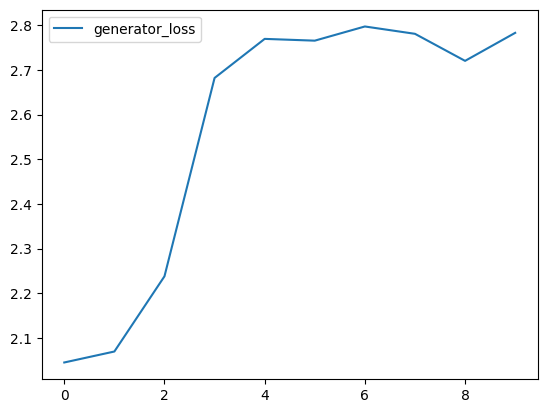

In [22]:
plt.plot(hist.history['g_loss'], label = 'generator_loss')
plt.legend()
plt.show()

In [23]:
image_trained  = generator.predict(np.random.randn(5,128,1))

1/1 [==============================] - 0s 335ms/step


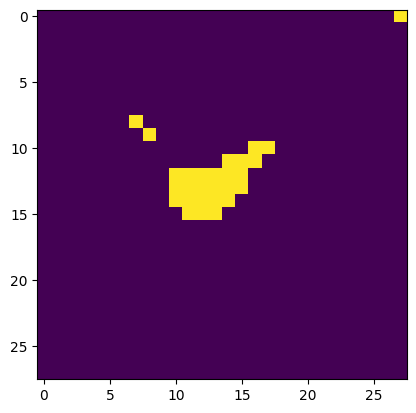

In [21]:
plt.imshow(image_trained[0])

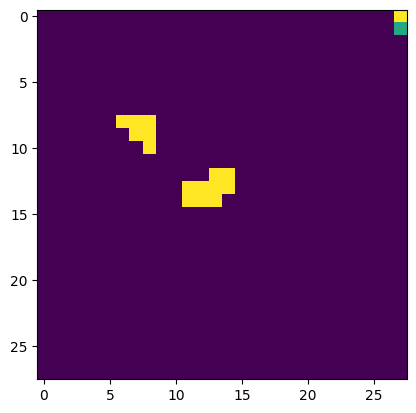

In [27]:
plt.imshow(image_trained[1])

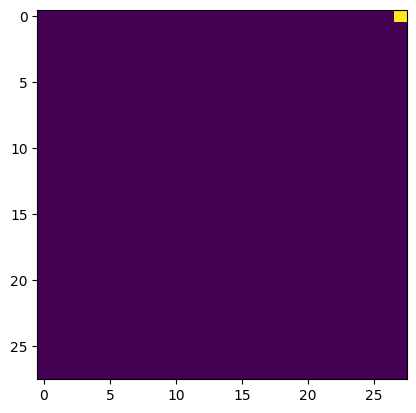

In [29]:
plt.imshow(image_trained[4])

In [21]:
# Try training your model for like 2k epochs to get better results